<a id='top'></a>
# Schools, Hospitals & House Prices in the DC Metro Area

#### Contributors: Muoyo Okome, VJ Paravastu

<a id='toc'></a>
### Table of Contents
1. [Problem Statement](#problemstatement)
2. [Data Sources](#datasources)
3. [Data Cleaning](#datacleaning)
4. [Hypothesis Tests](#hypothesistests)
    - [1 – Percentage of Private Schools in a County](#test1) 
    - [2 – People Per Hospital in a County](#test2) 
    - [3 – People Per School in a County](#test3) 
    - [4 – Percentage of Private Schools in a County, Revisited](#test4) 
    - [5 – Public Schools Per Person in a County](#test5) 
    - [6 – Public Schools Per Person in a County](#test6)     
5. [Findings](#findings)
6. [Next Steps](#nextsteps)

In [1]:
# Import necessary libraries
import warnings
import pandas as pd
from scipy import stats
from statsmodels.stats.weightstats import ztest
warnings.filterwarnings('ignore')

<a id='problemstatement'></a>
### Problem Statement

The goal of this analysis is to better understand house prices in the DC Metro Area, and some of the factors they may have a relationship with, viewed at the county level. 

Specifically we looked at the median house price in each county, the number of hospitals per county, the number of public schools per county, and the number of private schools per county. We also examined how these variables differed in subsets of the poplulation with lower house prices vs higher house prices.

[Back to Top ↑](#top)

<a id='datasources'></a>
### Data Sources

We sourced our data from Zillow, the Homeland Infrastructure Foundation, and the US Census Bureau, and merged the data together at the county level.

#### **[Zillow Home Value Index](https://www.zillow.com/research/data/)**

- **[Housing:](https://www.zillow.com/research/data/)**  A smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. Zillow has published [an overview of ZHVI](https://www.zillow.com/research/zhvi-methodology-2019-highlights-26221/) and [a deep-dive into its methodology](https://www.zillow.com/research/zhvi-methodology-2019-deep-26226/).

#### **[HIFLD Open Data](https://hifld-geoplatform.opendata.arcgis.com/)**

- **[Public Schools:](https://hifld-geoplatform.opendata.arcgis.com/datasets/public-schools)** This Public Schools feature dataset is composed of all Public elementary and secondary education facilities in the United States as defined by the Common Core of Data ([CCD](https://nces.ed.gov/ccd/)), National Center for Education Statistics ([NCES](https://nces.ed.gov)), US Department of Education for the 2015-2016 school year. This includes all Kindergarten through 12th grade schools as tracked by the Common Core of Data. 

- **[Private Schools](https://hifld-geoplatform.opendata.arcgis.com/datasets/private-schools)** This Private Schools feature dataset is composed of private elementary and secondary education facilities in the United States as defined by the Private School Survey ([PSS](https://nces.ed.gov/surveys/pss/)), National Center for Education Statistics ([NCES](https://nces.ed.gov)), US Department of Education for the 2015-2016 school year. This includes all prekindergarten through 12th grade schools as tracked by the PSS.

- **[Hospitals:](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals)** This feature class/shapefile contains locations of Hospitals for 50 US states, Washington D.C., US territories of Puerto Rico, Guam, American Samoa, Northern Mariana Islands, Palau, and Virgin Islands. 

#### **[US Census Bureau](https://www2.census.gov)**

- **[Population:](https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html#par_textimage_1383669527)** This dataset features all the files containing Vintage 2018 county population estimates by demographic characteristics.
<br> 

[Back to Top ↑](#top)

<a id='datacleaning'></a>
### Data Cleaning

Before beginning analysis, we limited our data from Zillow to 22 of the 23 counties of the [Washington DC Metro Area](https://en.wikipedia.org/wiki/Washington_metropolitan_area). Rappahannock County, VA, the smallest county in the area with a population of less than 7500 people, did not have enough data to work with. We also chose to focus only on the June 2019 Median Price Estimates column, dropping all other months, as well as excluding a few other columns we didn't need.

Because the datasets from Zillow & HIFLD Open Data used slightly different conventions for the county names, we created a dictionary that used Zillow's county names as the keys and [FIPS County Codes](https://en.wikipedia.org/wiki/FIPS_county_code) as the values, allowing us to easily merge with the HIFLD datasets for Public Schools, Private Schools, and Hospitals, which all featured a CountyFIPS column.

Finally, we merged in the population data from US Census by County Name and stored the number of Public & Private Schools and Hospitals in each county, as well as the ratios between Public & Private Schools, and the number of Hospitals, Schools, Public Schools, and Private Schools per person, to be used later on.

In [2]:
# Read in original data
df_housing = pd.read_csv('../data/County_Zhvi_AllHomes.csv', encoding='latin1')
df_public_schools = pd.read_csv('../data/Public_Schools.csv')
df_private_schools = pd.read_csv('../data/Private_Schools.csv')
df_hospitals = pd.read_csv('../data/Hospitals.csv')
df_population = pd.read_csv('../data/PEP_2018_PEPANNRES_with_ann.csv', encoding='latin1')

To make the project more modular and easier to follow & build upon, we created separate .py files to handle the heavy lifting for our data cleaning, visualizations, and hypothesis tests, as well as a class called **DCMetroInfo** (located in **utils.py**), which stores several subsets of the DC Metro Area counties that we repeatedly use for our statistical tests and visualizations. You can see our .py files and **DCMetroInfo** object, **dcmi**, directly below.

In [3]:
# Clean data & load into final dataframe
%run ../python_files/data_cleaning

In [4]:
df_dcmetro = clean_data(df_housing, df_public_schools, df_private_schools, df_hospitals, df_population)

In [5]:
# Import python files we've created to help
%run ../python_files/utils
%run ../python_files/hypothesis_tests
%run ../python_files/visualizations

# Additional calculations about DC Metro Counties to be used for tests & visualizations
dcmi = DCMetroInfo(df_dcmetro)



[Back to Top ↑](#top)

<a id='hypothesistests'></a>
### Hypothesis Tests

We selected a significance level of $\alpha=$0.05 for all hypothesis tests.

For all tests, we also divided our data into 2 distinct groups: **counties with lower house prices** and **counties with higher house prices**, using the median house price value of our DC Metro Area dataset, $352,704, as the midpoint by which we divided them.

<a id='test1'></a>
### Test 1 – Percentage of Private Schools in a County

We set our null & alternative hypotheses as follows:

$H_0:$ There is no difference between the percentage of private schools (# of Private Schools / # of Total Schools) in counties with lower house prices compared to counties with higher house prices. 

$H_A:$ There is a statistically significant difference between the percentage of private schools in counties with lower house prices compared to counties with higher house prices.

To test these claims, we divided our counties into those with lower & higher house prices, as previously described above, and also into those with lower & higher percentage of private schools, using the median private school percentage of our DC Metro Area dataset, 32%, as the midpoint by which we divided them.

We then performed a chi square test to test whether the variance observed between our two groups suggests their percentage of private schools are the same or different.

In [6]:
# Chi Square Test - p value = 0.0330062576612325

chi2_contingency([[ len(dcmi.high_price_low_pct_private_schools), len(dcmi.high_price_high_pct_private_schools) ],
                  [ len(dcmi.low_price_low_pct_private_schools), len(dcmi.low_price_high_pct_private_schools) ]])

(4.545454545454546, 0.0330062576612325, 1, array([[5.5, 5.5],
        [5.5, 5.5]]))

### Test 1 Results

<p>$\chi^2 = 4.55$
<p>$p = 0.033$

Because our p value of 0.033 is less than $\alpha$=0.05 (meaning there is only a 3% chance of seeing this result when the null hypothesis is true), we reject the null hypothesis.

Our findings suggest that there is a statistically significant difference between the percentage of private schools in counties with lower house prices compared to counties with higher house prices.
    
The bar plots below support those findings, with most of the counties in the dataset falling into the quadrants representing higher price, higher % private schools OR lower price, lower % private schools, while the other combinations were more rare. 
    
While our test result refers to the number of counties falling in each quadrant, we also plot the actual percentage of private for each county as well as the means and 95% confidence intervals of each group to better illustrate the relationship we've described.

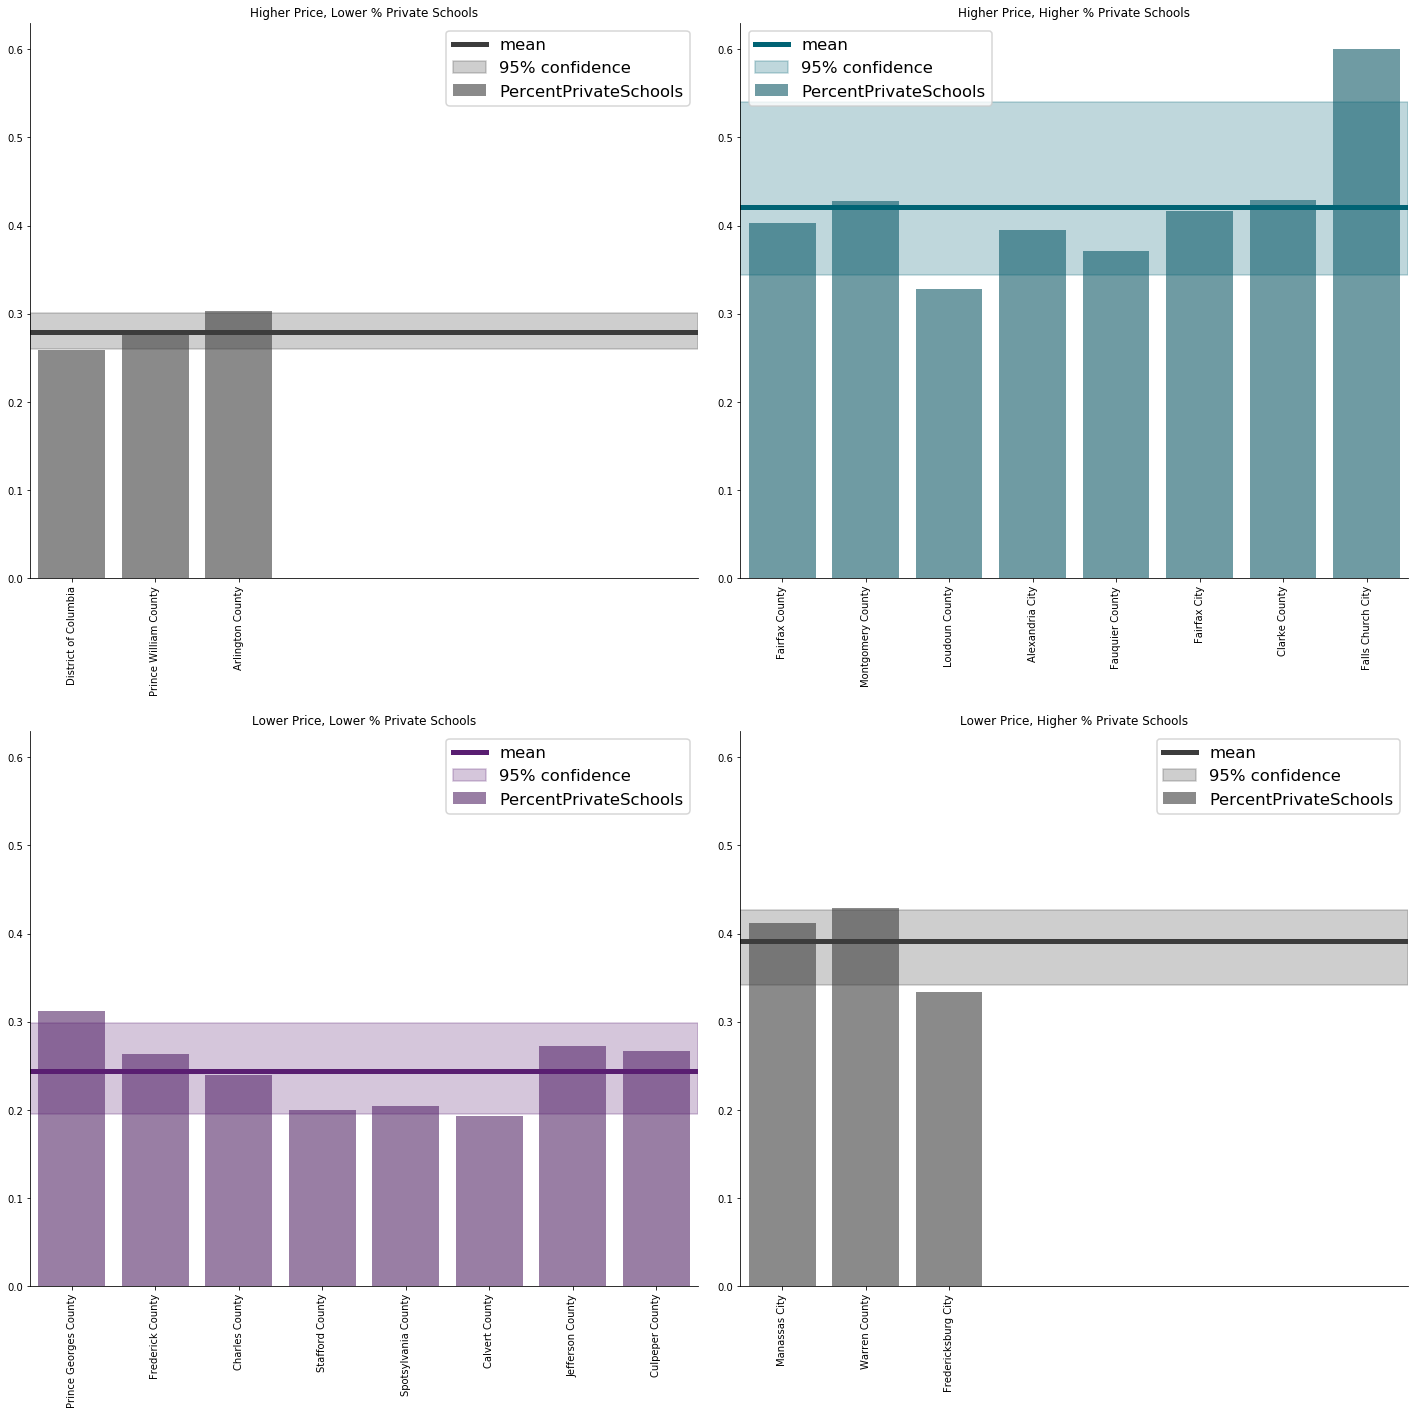

In [7]:
barplots_2x2_matrix(dcmi, 'RegionName', 'PercentPrivateSchools');

[Back to Top ↑](#top)

<a id='test2'></a>
### Test 2 – People Per Hospital in a County

We set our null & alternative hypotheses as follows:

$H_0:$ There is no difference between the number of people per hospital in counties with lower house prices compared to counties with higher house prices. 

$H_A:$ There is a statistically significant difference between the number of people per hospital in counties with lower house prices compared to counties with higher house prices.

To test these claims, we divided our counties into those with lower & higher house prices, as previously described above.

We then performed a z test to test whether the population means of our 2 groups are the same or different.

In [8]:
# Z tests comparing counties with lower house prices to counties with higher house prices

In [9]:
ztest (dcmi.low_price_counties['PeoplePerHospital'], dcmi.high_price_counties['PeoplePerHospital'])

(0.2676751711328554, 0.7889493631674214)

### Test 2 Results

<p>$z = 0.26$
<p>$p = 0.79$

Because our p value of 0.79 is greater than $\alpha$=0.05 (meaning there is a 79% chance of seeing this result when the null hypothesis is true), we fail to reject the null hypothesis.

Our findings suggest that there is no statistically significant difference between the number of people per hospital in counties with lower house prices compared to counties with higher house prices.
    
The bar plots below support those findings, with the means and 95% confidence intervals of the two groups looking remarkably similar.

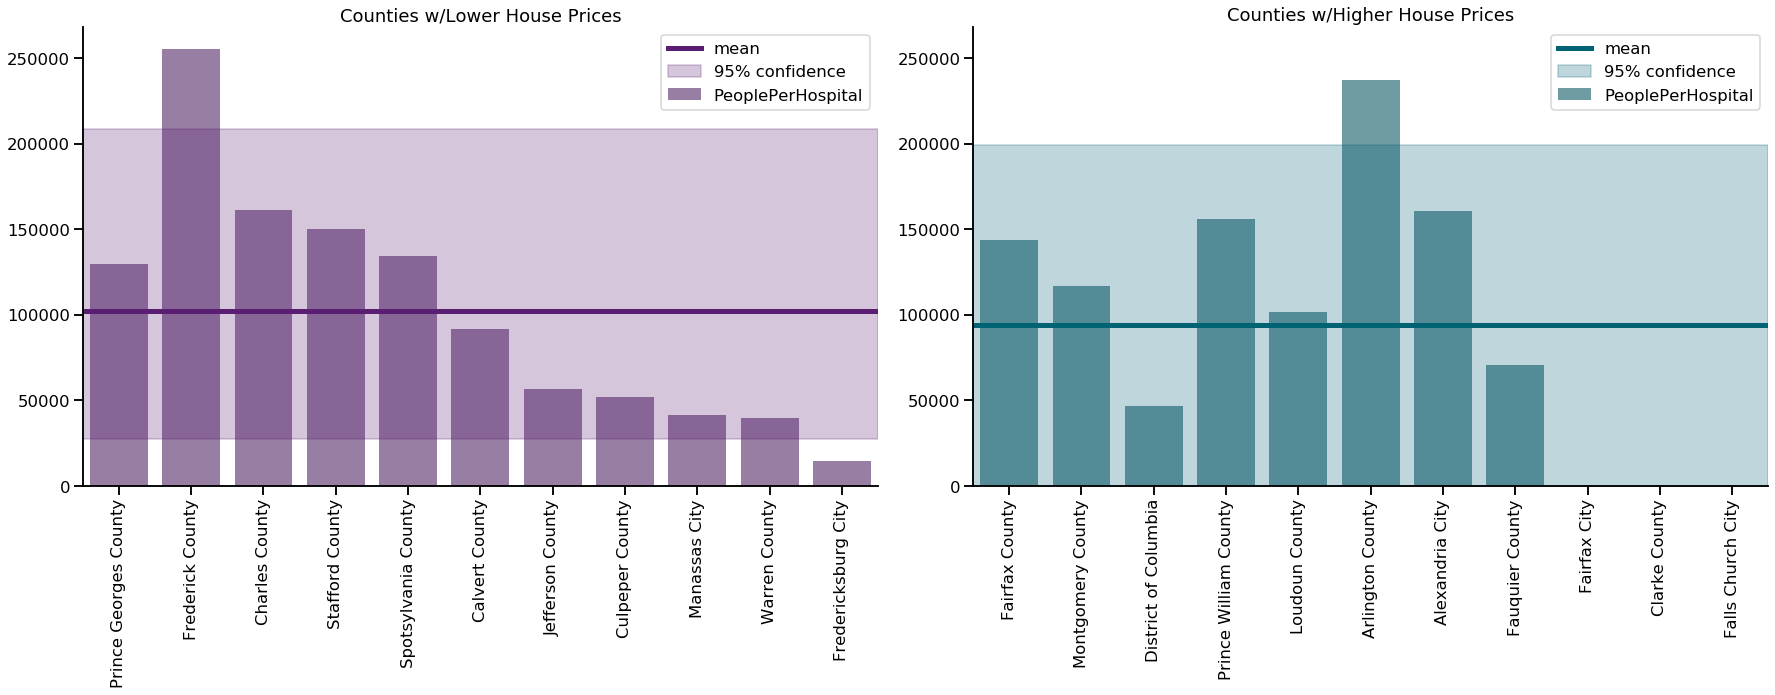

In [10]:
barplots_side_by_side(dcmi, 'RegionName', 'PeoplePerHospital', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

[Back to Top ↑](#top)

<a id='test3'></a>
### Test 3 – People Per School in a County

We set our null & alternative hypotheses as follows:

$H_0:$ There is no difference between the number of people per school in counties with lower house prices compared to counties with higher house prices. 

$H_A:$ There is a statistically significant difference between the number of people per school in counties with lower house prices compared to counties with higher house prices.

To test these claims, we divided our counties into those with lower & higher house prices, as previously described above.

We then performed a z test to test whether the population means of our 2 groups are the same or different.

In [11]:
ztest (dcmi.low_price_counties['PeoplePerSchool'], dcmi.high_price_counties['PeoplePerSchool'])

(0.41487340816509116, 0.6782345773522396)

### Test 3 Results

<p>$z = 0.41$
<p>$p = 0.68$

Because our p value of 0.68 is greater than $\alpha$=0.05 (meaning there is a 68% chance of seeing this result when the null hypothesis is true), we fail to reject the null hypothesis.

Our findings suggest that there is no statistically significant difference between the number of people per school in counties with lower house prices compared to counties with higher house prices.
    
The bar plots below support those findings, with the means and 95% confidence intervals of the two groups showing a lot of similarity.

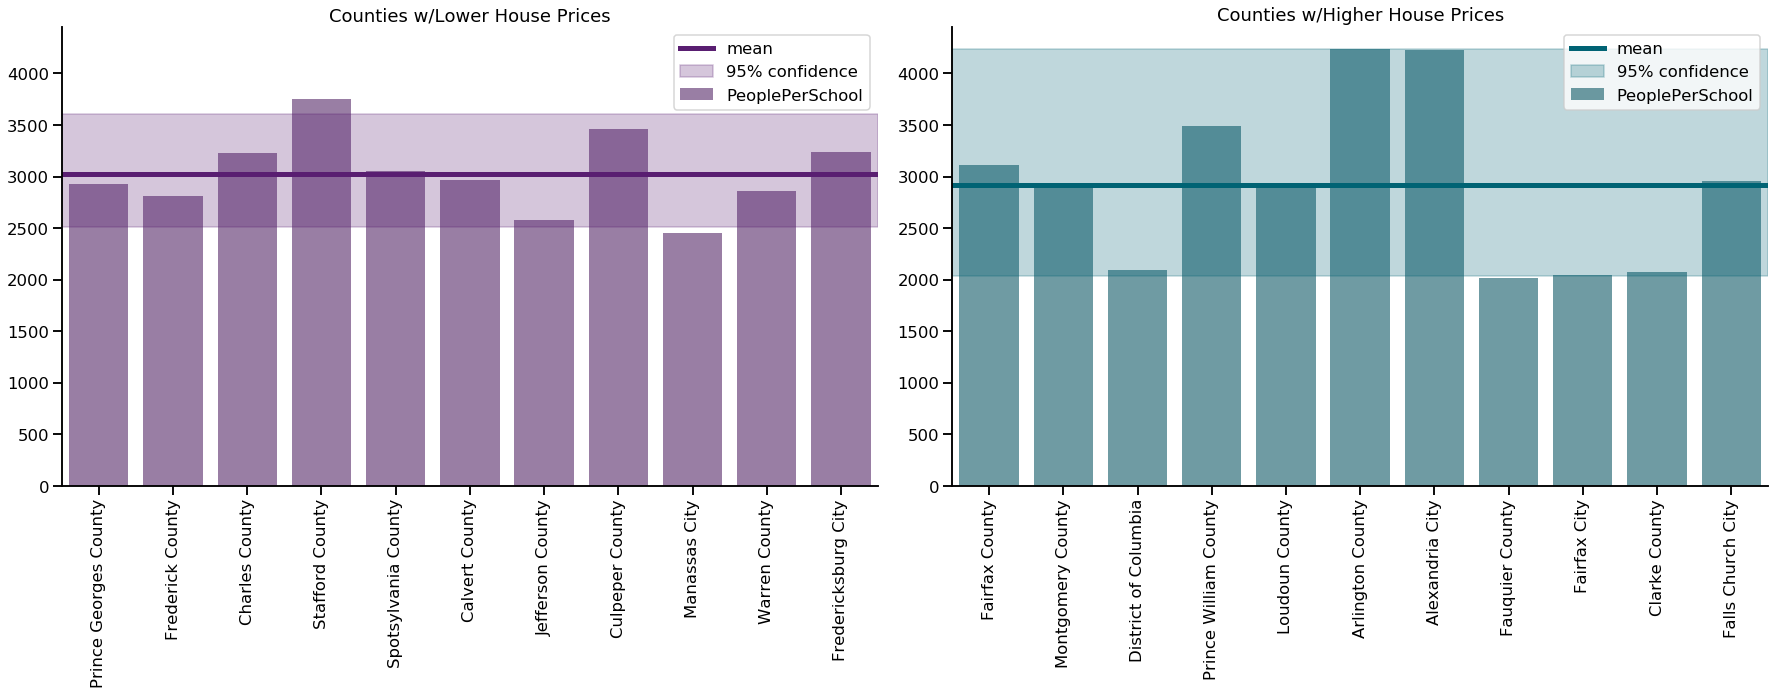

In [12]:
barplots_side_by_side(dcmi, 'RegionName', 'PeoplePerSchool', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

[Back to Top ↑](#top)

<a id='test4'></a>
### Test 4 – Percentage of Private Schools in a County, Revisited

This test looks at the same variables as test 1, but this time with a Z Test.

We set our null & alternative hypotheses as follows:

$H_0:$ There is no difference between the percentage of private schools (# of Private Schools / # of Total Schools) in counties with lower house prices compared to counties with higher house prices. 

$H_A:$ There is a statistically significant difference between the percentage of private schools in counties with lower house prices compared to counties with higher house prices.

To test these claims, we divided our counties into those with lower & higher house prices, as previously described above.

We then performed a z test to test whether the population means of our 2 groups are the same or different.

In [13]:
ztest (dcmi.low_price_counties['PercentPrivateSchools'], dcmi.high_price_counties['PercentPrivateSchools'])

(-2.6318370223362892, 0.008492459061615488)

### Test 4 Results

<p>$z = -2.63$
<p>$p = 0.0085$

Because our p value of 0.008 is less than $\alpha$=0.05 (meaning there is only a 0.8% chance of seeing this result when the null hypothesis is true), we reject the null hypothesis.

Our findings suggest that there is a statistically significant difference between the percentage of private schools in counties with lower house prices compared to counties with higher house prices. Since this is the same inference we drew from test 1, it is comforting that our results agree with each other.
    
The bar plots below support those findings, with the means of the two groups appearing to be quite different.

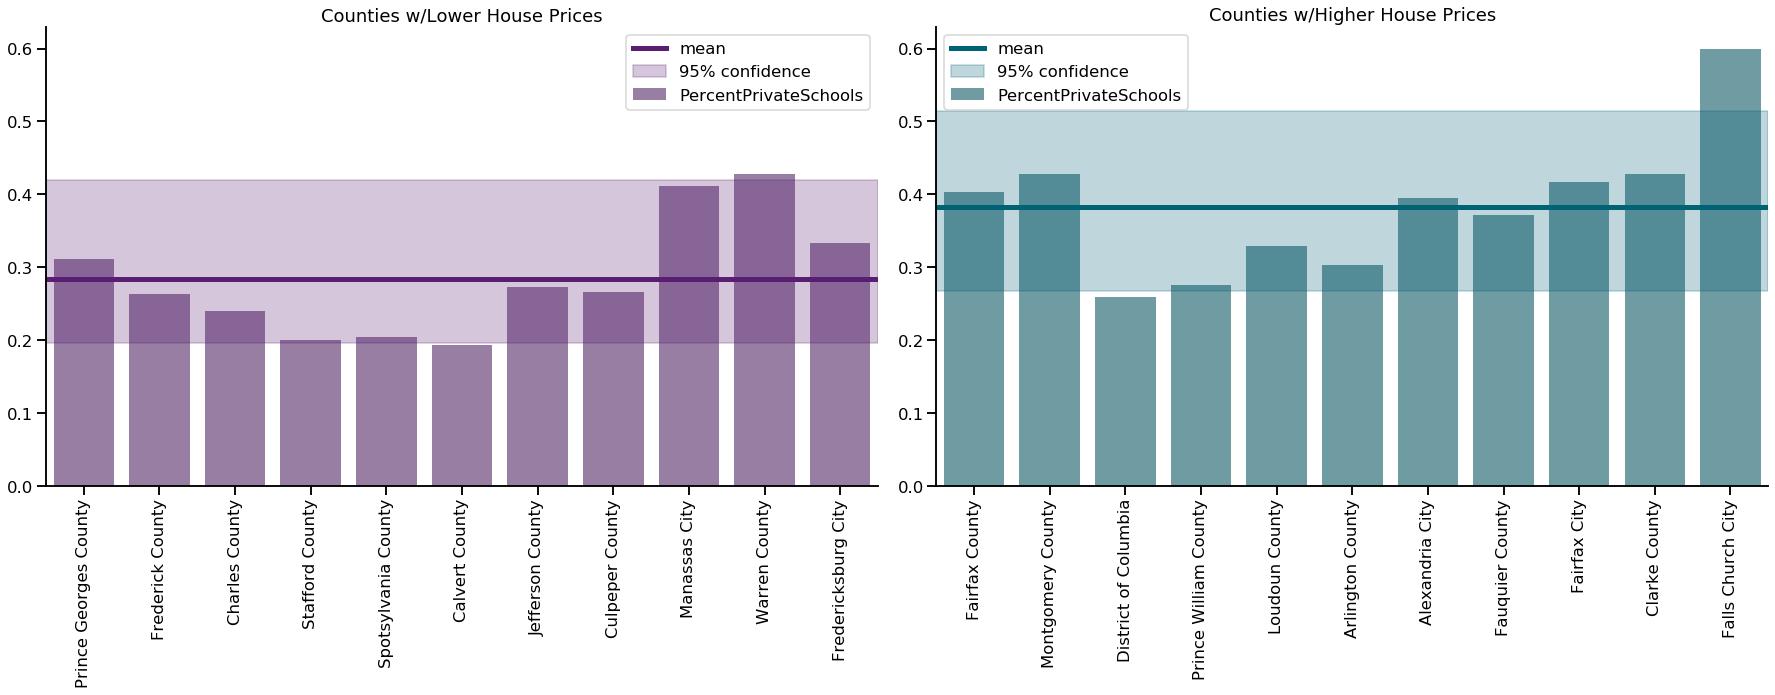

In [14]:
barplots_side_by_side(dcmi, 'RegionName', 'PercentPrivateSchools', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

[Back to Top ↑](#top)

<a id='test5'></a>
### Test 5 – Private Schools Per Person in a County

We set our null & alternative hypotheses as follows:

$H_0:$ There is no difference between the number of private schools per person in counties with lower house prices compared to counties with higher house prices. 

$H_A:$ There is a statistically significant difference between the number of private schools per person in counties with lower house prices compared to counties with higher house prices.

To test these claims, we divided our counties into those with lower & higher house prices, as previously described above.

We then performed a z test to test whether the population means of our 2 groups are the same or different.

In [15]:
ztest (dcmi.low_price_counties['PrivateSchoolsPerPerson'], dcmi.high_price_counties['PrivateSchoolsPerPerson'])

(-2.372554466283912, 0.017665558355976503)

### Test 5 Results

<p>$z = -2.37$
<p>$p = 0.017$

Because our p value of 0.017 is less than $\alpha$=0.05 (meaning there is only a 2% chance of seeing this result when the null hypothesis is true), we reject the null hypothesis.

Our findings suggest that there is a statistically significant difference between the number of private schools per person in counties with lower house prices compared to counties with higher house prices. This makes a lot of sense given what we observed in tests 1 and 4.
    
The bar plots below support those findings, with the means of the two groups again appearing distinct.

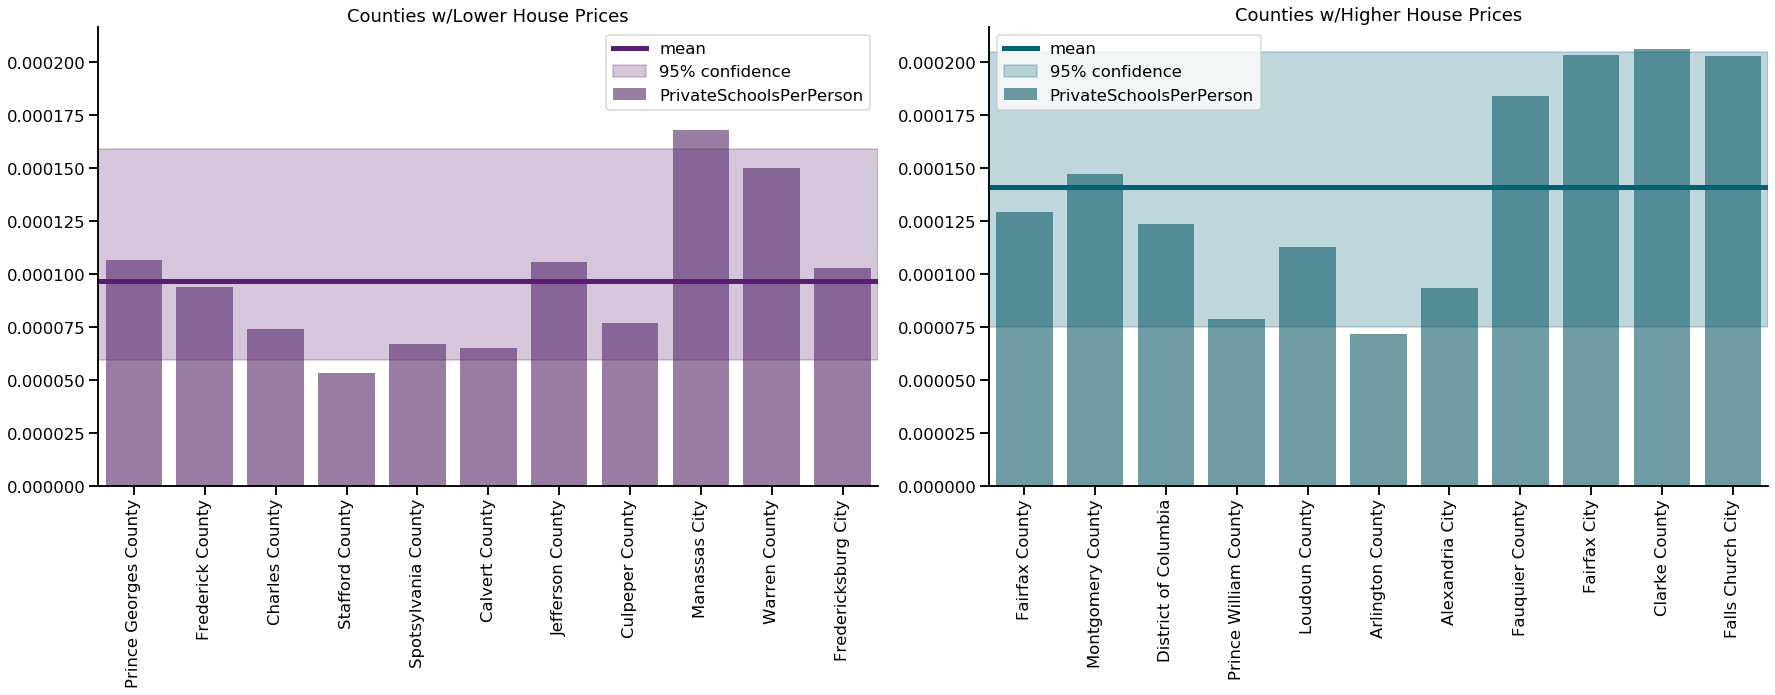

In [16]:
barplots_side_by_side(dcmi, 'RegionName', 'PrivateSchoolsPerPerson', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

[Back to Top ↑](#top)

<a id='test6'></a>
### Test 6 – Public Schools Per Person in a County

We set our null & alternative hypotheses as follows:

$H_0:$ There is no difference between the number of private schools per person in counties with lower house prices compared to counties with higher house prices. 

$H_A:$ There is a statistically significant difference between the number of private schools per person in counties with lower house prices compared to counties with higher house prices.

To test these claims, we divided our counties into those with lower & higher house prices, as previously described above.

We then performed a z test to test whether the population means of our 2 groups are the same or different.

In [17]:
ztest (dcmi.low_price_counties['PublicSchoolsPerPerson'], dcmi.high_price_counties['PublicSchoolsPerPerson'])

(0.4811415006000532, 0.6304159343470777)

### Test 6 Results

<p>$z = 0.48$
<p>$p = 0.63$

Because our p value of 0.63 is greater than $\alpha$=0.05 (meaning there is a 63% chance of seeing this result when the null hypothesis is true), we fail to reject the null hypothesis.

Our findings suggest that there is no statistically significant difference between the number of public schools per person in counties with lower house prices compared to counties with higher house prices.
    
The bar plots below support those findings, with the means and 95% confidence intervals of the two groups showing strong similarity.

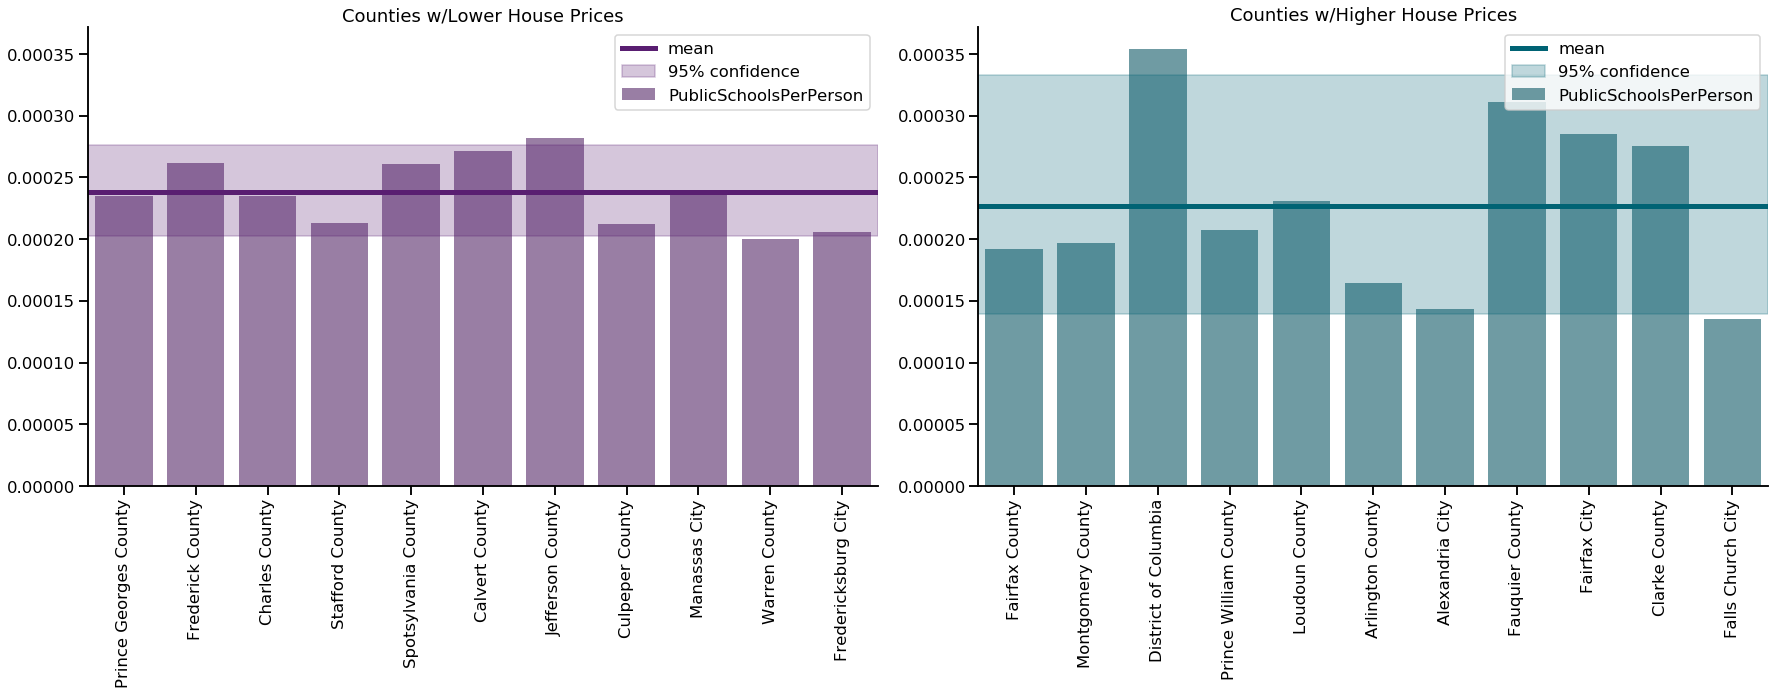

In [18]:
barplots_side_by_side(dcmi, 'RegionName', 'PublicSchoolsPerPerson', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

<p></p>
<p></p>
<p></p>
   

[Back to Top ↑](#top)

<a id='findings'></a>
### Findings

#### **Statistically significant findings:**

- Counties with higher house prices have more private schools per person

- Counties with higher house prices have a higher % of private schools

#### **No clear relationship:**

- No clear relationship between house prices & number of hospitals

- No clear relationship between house prices & people per school

[Back to Top ↑](#top)

<a id='nextsteps'></a>
### Next Steps

1. Analyze factors that may help to predict house prices in the Washington DC metro area. 

2. Work with more granular data to enable insights on the neighborhood, zip code, and individual home level. 

3. Perform regression analysis to help identify relationships between factors and house prices.

[Back to Top ↑](#top)